In [1]:
from export import export_image_encoder, export_text_model, export_token_embedding

from model import LlavaModel
import torch

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/exir/passes/_quant_patterns_and_replacements.py:106: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @impl_abstract("quantized_decomposed::embedding_byte.out")
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/exir/passes/_quant_patterns_and_replacements.py:153: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @impl_abstract("quantized_decomposed::embedding_byte.dtype_out")
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/exir/passes/_quant_patterns_and_replacements.py:228: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.reg

In [2]:
llava_model = LlavaModel()
llava = llava_model.get_eager_model()

llava = llava.to(torch.float32)  # overflow error with fp16

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]
[INFO 2024-07-12 17:15:24,914 sdpa_with_kv_cache.py:24] Loading custom ops library: /Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/examples/models/llama2/custom_ops/libcustom_ops_aot_lib.dylib


In [3]:
prompt_before_image, resized, prompt_after_image = llava_model.get_example_inputs()

In [4]:
prefill_logits = llava.prefill(prompt_before_image, resized, prompt_after_image)

In [5]:
print(prefill_logits)

tensor([[[ 1.4072,  0.7952, -0.3502,  ...,  2.0938,  3.0346,  1.7648],
         [-9.5823, -5.0563, -1.2308,  ..., -6.2960, -8.3478, -7.7177],
         [-5.5127, -6.3697,  8.1133,  ..., -3.5720, -1.9828, -2.7889],
         ...,
         [-5.6315, -2.3222,  8.8651,  ..., -1.3108, -3.9976, -2.9413],
         [-3.1874, -1.6479,  7.5750,  ...,  0.6132, -0.3697,  1.1412],
         [-1.1888, -1.4724,  9.7332,  ...,  1.5810,  1.8806,  1.8634]]],
       grad_fn=<UnsafeViewBackward0>)


In [4]:
image_encoder_ep = export_image_encoder(llava, resized)

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/export/_unlift.py:59: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  getattr_node = gm.graph.get_attr(lifted_node)
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/fx/graph.py:1568: UserWarning: Node lifted_tensor_0 target lifted_tensor_0 lifted_tensor_0 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/fx/graph.py:1568: UserWarning: Node lifted_tensor_1 target lifted_tensor_1 lifted_tensor_1 of  does not reference an nn.Module, 

In [6]:
embeddings = llava.prefill_embedding(prompt_before_image, resized, prompt_after_image)

In [9]:
text_model_ep = export_text_model(llava, embeddings)


[INFO 2024-07-12 15:36:44,734 export_llama_lib.py:417] Applying quantizers: []
[INFO 2024-07-12 15:36:44,749 sdpa_with_kv_cache.py:24] Loading custom ops library: /Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/examples/models/llama2/custom_ops/libcustom_ops_aot_lib.dylib
[INFO 2024-07-12 15:36:44,915 __init__.py:24] Skipping import of cpp extensions
[INFO 2024-07-12 15:36:45,382 config.py:58] PyTorch version 2.5.0.dev20240618 available.
[INFO 2024-07-12 15:36:45,385 config.py:95] TensorFlow version 2.16.1 available.


linear: layers.0.attention.wq, in=4096, out=4096
linear: layers.0.attention.wk, in=4096, out=4096
linear: layers.0.attention.wv, in=4096, out=4096
linear: layers.0.attention.wo, in=4096, out=4096
linear: layers.0.feed_forward.w1, in=4096, out=11008
linear: layers.0.feed_forward.w2, in=11008, out=4096
linear: layers.0.feed_forward.w3, in=4096, out=11008
linear: layers.1.attention.wq, in=4096, out=4096
linear: layers.1.attention.wk, in=4096, out=4096
linear: layers.1.attention.wv, in=4096, out=4096
linear: layers.1.attention.wo, in=4096, out=4096
linear: layers.1.feed_forward.w1, in=4096, out=11008
linear: layers.1.feed_forward.w2, in=11008, out=4096
linear: layers.1.feed_forward.w3, in=4096, out=11008
linear: layers.2.attention.wq, in=4096, out=4096
linear: layers.2.attention.wk, in=4096, out=4096
linear: layers.2.attention.wv, in=4096, out=4096
linear: layers.2.attention.wo, in=4096, out=4096
linear: layers.2.feed_forward.w1, in=4096, out=11008
linear: layers.2.feed_forward.w2, in=1100

RuntimeError:         Encountered duplicated inputs that are mutated in the graph you are trying to export.
        This functionality is currently not supported. If needed, please file a github issue.

        fw_metadata=ViewAndMutationMeta(input_info=[InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=True, mutates_metadata=False, mutations_hidden_from_autograd=False, mutations_under_no_grad_or_inference_mode=True, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False), InputAliasInfo(is_leaf=False, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=False), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=False)], output_info=[OutputAliasInfo(output_type=<OutputType.non_alias: 1>, raw_type=<class 'torch._subclasses.functional_tensor.FunctionalTensor'>, base_idx=None, dynamic_dims={1}, requires_grad=False, functional_tensor=None)], num_intermediate_bases=0, keep_input_mutations=False, traced_tangents=[], subclass_inp_meta=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903], subclass_fw_graph_out_meta=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128], subclass_tangent_meta=[], is_train=False, traced_tangent_metas=None, num_symints_saved_for_bw=None, grad_enabled_mutation=None, deterministic=None, static_parameter_indices=[], tokens={}, indices_of_inputs_that_requires_grad_with_mutations_in_bw=[])
            

In [6]:
from executorch.examples.models.llama2.export_llama_lib import build_args_parser
from executorch.examples.models.llama2.source_transformation.sdpa import replace_sdpa_with_custom_op
from executorch.examples.models.llama2.source_transformation.quantize import get_quant_weight_transform
from executorch.examples.models.llama2.builder import DType

llava_text_model = llava.text_model

dtype_override = DType.fp32
parser = build_args_parser()
args = parser.parse_args(['-X', '-qmode', '8da4w', '--group_size', '128', '--embedding-quantize', '4,32'])
quant_transform = get_quant_weight_transform(args, dtype_override, False)
source_transforms = [replace_sdpa_with_custom_op, quant_transform]

for transform in source_transforms:
    llava_text_model = transform(llava_text_model)

[INFO 2024-07-12 11:06:25,263 sdpa_with_kv_cache.py:24] Loading custom ops library: /Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/examples/models/llama2/custom_ops/libcustom_ops_aot_lib.dylib
[INFO 2024-07-12 11:06:25,335 __init__.py:24] Skipping import of cpp extensions
[INFO 2024-07-12 11:06:25,963 config.py:58] PyTorch version 2.5.0.dev20240618 available.
[INFO 2024-07-12 11:06:25,965 config.py:95] TensorFlow version 2.16.1 available.


linear: layers.0.attention.wq, in=4096, out=4096
linear: layers.0.attention.wk, in=4096, out=4096
linear: layers.0.attention.wv, in=4096, out=4096
linear: layers.0.attention.wo, in=4096, out=4096
linear: layers.0.feed_forward.w1, in=4096, out=11008
linear: layers.0.feed_forward.w2, in=11008, out=4096
linear: layers.0.feed_forward.w3, in=4096, out=11008
linear: layers.1.attention.wq, in=4096, out=4096
linear: layers.1.attention.wk, in=4096, out=4096
linear: layers.1.attention.wv, in=4096, out=4096
linear: layers.1.attention.wo, in=4096, out=4096
linear: layers.1.feed_forward.w1, in=4096, out=11008
linear: layers.1.feed_forward.w2, in=11008, out=4096
linear: layers.1.feed_forward.w3, in=4096, out=11008
linear: layers.2.attention.wq, in=4096, out=4096
linear: layers.2.attention.wk, in=4096, out=4096
linear: layers.2.attention.wv, in=4096, out=4096
linear: layers.2.attention.wo, in=4096, out=4096
linear: layers.2.feed_forward.w1, in=4096, out=11008
linear: layers.2.feed_forward.w2, in=1100

In [8]:

llava_text_model = llava.text_model
ref = llava_text_model(embeddings, torch.tensor([0]))
print(ref)

tensor([[[ 1.4072,  0.7952, -0.3502,  ...,  2.0938,  3.0346,  1.7648],
         [-9.5823, -5.0563, -1.2308,  ..., -6.2960, -8.3478, -7.7177],
         [-5.5127, -6.3697,  8.1133,  ..., -3.5720, -1.9828, -2.7889],
         ...,
         [-5.6315, -2.3222,  8.8651,  ..., -1.3108, -3.9976, -2.9413],
         [-3.1874, -1.6479,  7.5750,  ...,  0.6132, -0.3697,  1.1412],
         [-1.1888, -1.4724,  9.7332,  ...,  1.5810,  1.8806,  1.8634]]],
       grad_fn=<UnsafeViewBackward0>)


In [9]:
print(llava.prefill_ref(prompt_before_image, resized, prompt_after_image))

(tensor([[[ 1.4072,  0.7952, -0.3502,  ...,  2.0938,  3.0346,  1.7648],
         [-9.5823, -5.0563, -1.2308,  ..., -6.2960, -8.3478, -7.7177],
         [-5.5127, -6.3697,  8.1133,  ..., -3.5720, -1.9828, -2.7889],
         ...,
         [-5.6315, -2.3222,  8.8651,  ..., -1.3108, -3.9975, -2.9413],
         [-3.1874, -1.6479,  7.5750,  ...,  0.6132, -0.3697,  1.1412],
         [-1.1888, -1.4724,  9.7332,  ...,  1.5810,  1.8806,  1.8634]]],
       grad_fn=<UnsafeViewBackward0>),)


In [8]:
dim = torch.export.Dim("token_dim", min=1, max=llava.text_model_args.max_seq_len - 1)
pos_dim = 1
text_model_dynamic_shapes = ({1: dim}, {0: pos_dim})

In [10]:
import math

import os
import re

from dataclasses import dataclass
from typing import Any, Dict, Optional, Tuple

import requests
import torch
from pathlib import Path
import torchvision

from executorch.examples.models.llama2.source_transformation.sdpa import replace_sdpa_with_custom_op
from executorch.examples.models.llava_encoder.model import get_prompt
from llava.constants import (
    IMAGE_TOKEN_INDEX,
)

from llava.mm_utils import get_model_name_from_path, tokenizer_image_token

from PIL import Image

from torch import nn
from torch.export import Dim
from torch.nn import functional as F
from torchvision.transforms import v2
from torchvision.transforms._functional_tensor import resize

from transformers import LlamaForCausalLM

model_name = get_model_name_from_path("liuhaotian/llava-v1.5-7b")
prompt = get_prompt("What are the things I should be cautious about when I visit here?", False, model_name)
input_ids = (
    tokenizer_image_token(
        prompt, llava_model.tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt"
    )
    .unsqueeze(0)
    .cpu()
)
index = torch.where(input_ids == IMAGE_TOKEN_INDEX)[1]
prompt_before_image = input_ids[:, :index]
# print(prompt_before_image.shape)
prompt_after_image = input_ids[:, index + 1 :]
# print(prompt_after_image.shape)
imagr = torchvision.io.read_image("./view.jpg")
ratio = max(imagr.shape[1], imagr.shape[2]) / llava_model.image_processor.crop_size["height"]
output_size = (int(imagr.shape[1] / ratio), int(imagr.shape[2] / ratio))
resized = torchvision.transforms.Resize(size=output_size)(imagr)

In [11]:
print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>
What are the things I should be cautious about when I visit here? ASSISTANT:


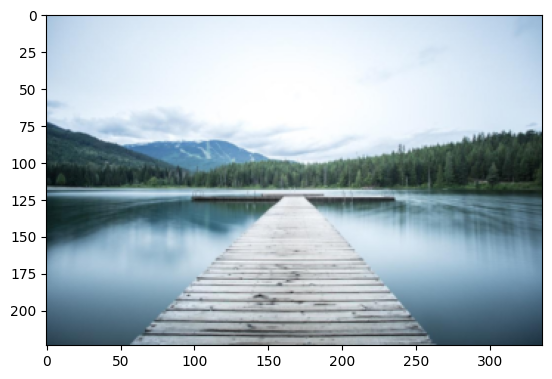

In [12]:
import matplotlib.pyplot as plt
plt.imshow(torchvision.transforms.ToPILImage()(resized))

In [ ]:
llava_model.model.generate(
    input_ids,
    images=resized,
    image_sizes
)

In [15]:
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import load_images, process_images
from llava.model.builder import load_pretrained_model

model_path = "liuhaotian/llava-v1.5-7b"
tokenizer, model, image_processor, context_len = (
    load_pretrained_model(
        model_path=model_path,
        model_base=None,
        model_name=get_model_name_from_path(model_path),
        device_map="cpu",
        device="cpu",
    )
)
img = load_images(["view.jpg"])
img_tensor = process_images(img, image_processor, model.config)

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


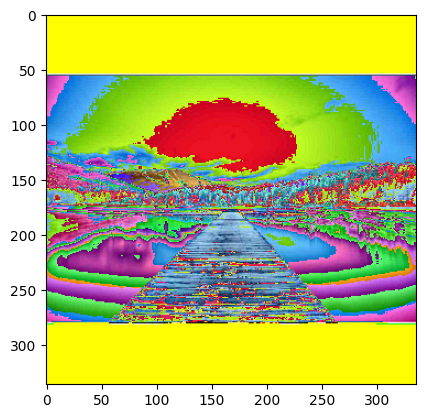

In [18]:
plt.imshow(torchvision.transforms.ToPILImage()(img_tensor.squeeze(0)))

In [19]:
preprocessed = llava.image_preprocess(resized)

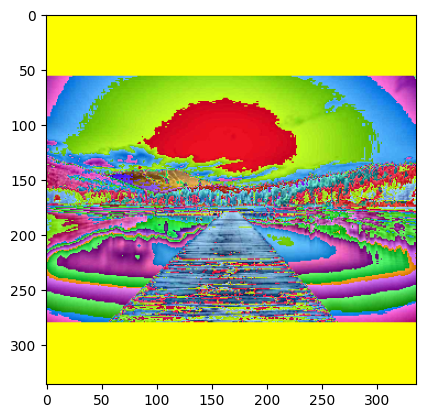

In [21]:
plt.imshow(torchvision.transforms.ToPILImage()(preprocessed.squeeze(0)))

In [28]:
position_ids = torch.arange(0, input_ids.shape[1], dtype=torch.long, device=input_ids.device)
_, _, _, _, inputs_embeds, _ = llava_model.model.prepare_inputs_labels_for_multimodal(
    input_ids, 
    position_ids=position_ids, 
    attention_mask=None, 
    past_key_values=None, 
    labels=None,
    images=preprocessed, 
    image_sizes=[preprocessed.size],
)
print(inputs_embeds)

tensor([[[ 0.0045, -0.0038,  0.0017,  ..., -0.0088,  0.0025, -0.0025],
         [-0.0112, -0.0129, -0.0121,  ...,  0.0090,  0.0118, -0.0081],
         [ 0.0195, -0.0058,  0.0061,  ...,  0.0171, -0.0052, -0.0212],
         ...,
         [-0.0187, -0.0017,  0.0177,  ...,  0.0238,  0.0052,  0.0101],
         [ 0.0066, -0.0161,  0.0117,  ..., -0.0103,  0.0148,  0.0073],
         [ 0.0039,  0.0015,  0.0055,  ..., -0.0042,  0.0151,  0.0024]]],
       grad_fn=<StackBackward0>)


In [44]:
llava_model.model.generate(input_ids, images=preprocessed, image_sizes=[preprocessed.size], do_sample=False, temperature=0.0, top_p=None, num_beams=1, max_new_tokens=50, use_cache=True)

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


TypeError: LlavaLlamaForCausalLM.forward() got an unexpected keyword argument 'cache_position'

In [29]:
print(inputs_embeds.shape)

torch.Size([1, 634, 4096])


In [30]:
actual_inputs_embeds = llava.prefill_embedding(prompt_before_image, resized, prompt_after_image)

In [31]:
print(actual_inputs_embeds.shape)

torch.Size([1, 634, 4096])


In [32]:
torch.allclose(inputs_embeds, actual_inputs_embeds)

True

In [34]:
ref_prefill_logits = llava.prefill_ref(prompt_before_image, resized, prompt_after_image)[0]

In [45]:
print(ref_prefill_logits)

tensor([[[ 1.4072,  0.7952, -0.3502,  ...,  2.0938,  3.0346,  1.7648],
         [-9.5823, -5.0563, -1.2308,  ..., -6.2960, -8.3478, -7.7177],
         [-5.5127, -6.3697,  8.1133,  ..., -3.5720, -1.9828, -2.7889],
         ...,
         [-5.6315, -2.3222,  8.8651,  ..., -1.3108, -3.9975, -2.9413],
         [-3.1874, -1.6479,  7.5750,  ...,  0.6132, -0.3697,  1.1412],
         [-1.1888, -1.4724,  9.7332,  ...,  1.5810,  1.8806,  1.8634]]],
       grad_fn=<UnsafeViewBackward0>)


: 

In [43]:
torch.allclose(ref_prefill_logits, prefill_logits, atol=1e-3)

True

In [9]:

from torch.nn.attention import SDPBackend

with torch.nn.attention.sdpa_kernel([SDPBackend.MATH]), torch.no_grad():
    text_export_program = torch.export.export(
        llava_text_model, 
        (embeddings, torch.tensor([0], dtype=torch.int64)), 
        dynamic_shapes=text_model_dynamic_shapes, 
    )

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functional are safe to not decompose. We found quantized_decomposed.choose_qparams_per_token_asymmetric.default to be one such op.
  warnings.warn(
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functional are safe to not decompose. We found quantized_decomposed.quantize_per_token.default to be one such op.
  warnings.warn(
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functio

In [10]:
text_export_program.module()(embeddings, torch.tensor([0], dtype=torch.int64))

: 

: 

In [21]:
from executorch.examples.models.llama2.builder import LlamaEdgeManager, DType
from executorch.examples.models.llama2.export_llama_lib import WeightType
from executorch.extension.llm.export.partitioner_lib import get_xnnpack_partitioner
from executorch.examples.models.llama2.source_transformation.sdpa import replace_sdpa_with_custom_op
from executorch.examples.models.llama2.source_transformation.quantize import get_quant_weight_transform
from executorch.examples.models.llama2.export_llama_lib import build_args_parser, get_quantizer_and_quant_params
from torch.ao.quantization.quantizer.xnnpack_quantizer import (
    get_symmetric_quantization_config,
    XNNPACKQuantizer,
)

class LlavaImageEncoder(torch.nn.Module):
    """ Takes images and prompts and encode them into embeddings. Result will be sent to the text model LlavaTextModel."""
    def __init__(self, llava):
        super().__init__()
        self.llava = llava

    def forward(self, image):
        return self.llava.image_embedding(image)
    
    
height = Dim("height", min=1, max=336)
width = Dim("width", min=28, max=336)
image_dynamic_shapes = [{1: height, 2: width}]

llava_image_encode = LlavaImageEncoder(llava)

# quantizer
linear_quantizer = XNNPACKQuantizer()
operator_config_dynamic = get_symmetric_quantization_config(
    is_per_channel=True, is_dynamic=True
)
linear_quantizer.set_global(operator_config_dynamic)
image_encoder_ep = LlavaEdgeManager(
    model=llava_image_encode,
    modelname="llava_image_encoder",
    weight_type=WeightType.LLAMA,
    dtype=DType.fp32,
    use_kv_cache=True,
    use_sdpa_with_kv_cache=True,
    example_inputs=(resized,),
    dynamic_shapes=image_dynamic_shapes,
).capture_pre_autograd_graph()

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/export/_unlift.py:59: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  getattr_node = gm.graph.get_attr(lifted_node)
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/fx/graph.py:1568: UserWarning: Node lifted_tensor_0 target lifted_tensor_0 lifted_tensor_0 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/fx/graph.py:1568: UserWarning: Node lifted_tensor_1 target lifted_tensor_1 lifted_tensor_1 of  does not reference an nn.Module, 

In [20]:
from executorch.backends.xnnpack.partition.xnnpack_partitioner import XnnpackPartitioner
executorch_program = image_encoder_ep.to_backend([XnnpackPartitioner()]).to_executorch()

[INFO 2024-07-10 16:26:15,832 xnnpack_partitioner.py:920] Found 257 subgraphs to be partitioned.
[INFO 2024-07-10 16:27:18,848 builder.py:276] Required memory for activation in bytes: [0, 173387968]


In [21]:
executorch_program.save_to_pte("llava_image_encoder.pte")

[INFO 2024-07-10 16:29:13,677 utils.py:115] Saved exported program to llava_image_encoder.pte


In [22]:
embed = torch.nn.Embedding(llava.model_.config.vocab_size, llava.model_.config.hidden_size, llava.model_.config.pad_token_id)
embed.load_state_dict(llava.model_.get_model().embed_tokens.state_dict(), strict=True, assign=True)
embed = embed.to(torch.float32)

In [23]:
token_dim_1 = Dim("token_dim_1", min=2, max=3518)
dynamic_shapes = [{1: token_dim_1}]

In [24]:
with torch.no_grad():
    token_embedding_ep = torch.export.export(embed, (prompt_before_image,), dynamic_shapes=dynamic_shapes)

In [43]:
from executorch.exir import to_edge, EdgeCompileConfig

embedding_program = to_edge(token_embedding_ep).to_executorch()
with open("llava_embedding.pte", "wb") as f:
    embedding_program.write_to_file(f)

In [46]:
from executorch.extension.pybindings.portable_lib import _load_for_executorch

m = _load_for_executorch("llava_embedding.pte")
embed1 = m.forward((torch.tensor([[1]], dtype=torch.int64), ))

[program.cpp:130] InternalConsistency verification requested but not available


In [25]:
embeddings = llava.prefill_embedding(prompt_before_image, resized, prompt_after_image)

In [26]:
from executorch.examples.models.llama2.builder import LlamaEdgeManager, DType
from executorch.examples.models.llama2.export_llama_lib import WeightType
from executorch.extension.llm.export.partitioner_lib import get_xnnpack_partitioner
from executorch.examples.models.llama2.source_transformation.sdpa import replace_sdpa_with_custom_op
from executorch.examples.models.llama2.source_transformation.quantize import get_quant_weight_transform
from executorch.examples.models.llama2.export_llama_lib import build_args_parser, get_quantizer_and_quant_params


llava_text_model = llava.text_model

dim = torch.export.Dim("token_dim", min=1, max=llava.text_model_args.max_seq_len - 1)
pos_dim = 1
text_model_dynamic_shapes = ({1: dim}, {0: pos_dim})

class LlavaEdgeManager(LlamaEdgeManager):
    def __init__(self, model, modelname, weight_type, dtype, use_kv_cache, use_sdpa_with_kv_cache, example_inputs):
        super().__init__(model, modelname, weight_type, dtype, use_kv_cache, use_sdpa_with_kv_cache, example_inputs)
    
    def _get_dynamic_shape(self) -> torch.Any:
        return text_model_dynamic_shapes
    
text_model_em = LlavaEdgeManager(
    model=llava_text_model,
    modelname="llava_text_model",
    weight_type=WeightType.LLAMA,
    dtype=DType.fp32,
    use_kv_cache=True,
    use_sdpa_with_kv_cache=True,
    example_inputs=(embeddings, torch.tensor([0], dtype=torch.int64))
)

dtype_override = DType.fp32
parser = build_args_parser()
args = parser.parse_args(['-X', '-qmode', '8da4w', '--group_size', '128', '--embedding-quantize', '4,32'])
quant_transform = get_quant_weight_transform(args, dtype_override, False)
pt2e_quant_params, quantizers, quant_dtype = get_quantizer_and_quant_params(args)

manager = (
    text_model_em
    .set_output_dir("./")
    .to_dtype(dtype_override)
    .source_transform([replace_sdpa_with_custom_op, quant_transform])
    .capture_pre_autograd_graph()
    .pt2e_quantize(quantizers)
)

[INFO 2024-07-11 17:10:43,764 export_llama_lib.py:417] Applying quantizers: []
[INFO 2024-07-11 17:10:43,767 sdpa_with_kv_cache.py:24] Loading custom ops library: /Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/examples/models/llama2/custom_ops/libcustom_ops_aot_lib.dylib
[INFO 2024-07-11 17:10:43,842 __init__.py:24] Skipping import of cpp extensions
[INFO 2024-07-11 17:10:44,474 config.py:58] PyTorch version 2.5.0.dev20240618 available.
[INFO 2024-07-11 17:10:44,475 config.py:95] TensorFlow version 2.16.1 available.


linear: layers.0.attention.wq, in=4096, out=4096
linear: layers.0.attention.wk, in=4096, out=4096
linear: layers.0.attention.wv, in=4096, out=4096
linear: layers.0.attention.wo, in=4096, out=4096
linear: layers.0.feed_forward.w1, in=4096, out=11008
linear: layers.0.feed_forward.w2, in=11008, out=4096
linear: layers.0.feed_forward.w3, in=4096, out=11008
linear: layers.1.attention.wq, in=4096, out=4096
linear: layers.1.attention.wk, in=4096, out=4096
linear: layers.1.attention.wv, in=4096, out=4096
linear: layers.1.attention.wo, in=4096, out=4096
linear: layers.1.feed_forward.w1, in=4096, out=11008
linear: layers.1.feed_forward.w2, in=11008, out=4096
linear: layers.1.feed_forward.w3, in=4096, out=11008
linear: layers.2.attention.wq, in=4096, out=4096
linear: layers.2.attention.wk, in=4096, out=4096
linear: layers.2.attention.wv, in=4096, out=4096
linear: layers.2.attention.wo, in=4096, out=4096
linear: layers.2.feed_forward.w1, in=4096, out=11008
linear: layers.2.feed_forward.w2, in=1100

W0711 17:11:17.782000 8283245568 torch/_export/__init__.py:92] +============================+
W0711 17:11:17.787000 8283245568 torch/_export/__init__.py:93] |     !!!   WARNING   !!!    |
W0711 17:11:17.788000 8283245568 torch/_export/__init__.py:94] +============================+
W0711 17:11:17.788000 8283245568 torch/_export/__init__.py:95] capture_pre_autograd_graph() is deprecated and doesn't provide any function guarantee moving forward.
W0711 17:11:17.788000 8283245568 torch/_export/__init__.py:96] Please switch to use torch.export instead.
[INFO 2024-07-11 17:11:34,950 builder.py:179] Using pt2e [] to quantizing the model...
[INFO 2024-07-11 17:11:34,950 builder.py:199] No quantizer provided, passing...


In [22]:
from executorch.exir import to_edge, EdgeCompileConfig

from executorch.backends.xnnpack.partition.xnnpack_partitioner import (
        XnnpackDynamicallyQuantizedPartitioner,
        # XnnpackFloatingPointPartitioner,
    )
executorch_program = manager.export_to_edge().to_backend([XnnpackDynamicallyQuantizedPartitioner()]).to_executorch().save_to_pte("llava_text_model.pte")

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functional are safe to not decompose. We found quantized_decomposed.choose_qparams_per_token_asymmetric.default to be one such op.
  warnings.warn(
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functional are safe to not decompose. We found quantized_decomposed.quantize_per_token.default to be one such op.
  warnings.warn(
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functio

In [27]:
with torch.no_grad():
    text_model_ep = torch.export.export(manager.pre_autograd_graph_module, manager.example_inputs, dynamic_shapes=manager._get_dynamic_shape())

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functional are safe to not decompose. We found quantized_decomposed.choose_qparams_per_token_asymmetric.default to be one such op.
  warnings.warn(
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functional are safe to not decompose. We found quantized_decomposed.quantize_per_token.default to be one such op.
  warnings.warn(
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/_subclasses/functional_tensor.py:362: UserWarning: At pre-dispatch tracing, we will assume that any custom op that is marked with CompositeImplicitAutograd and functio

In [28]:
with torch.no_grad():
    image_encoder_ep = torch.export.export(image_encoder_ep.pre_autograd_graph_module, image_encoder_ep.example_inputs, dynamic_shapes=image_encoder_ep.dynamic_shapes)

In [29]:
from executorch.exir import to_edge, EdgeCompileConfig

edge_ep = to_edge({
    "image_encoder": image_encoder_ep,
    "token_embedding": token_embedding_ep,
    "text_model": text_model_ep,
}, compile_config=EdgeCompileConfig(_check_ir_validity=False))

In [37]:
from executorch.exir.dialects._ops import ops as exir_ops

SUPPORTED_OPS = [
    # exir_ops.edge.aten.div.Tensor,
    # exir_ops.edge.aten.add.Tensor,
    exir_ops.edge.aten.clamp.default,
    # exir_ops.edge.aten.sub.Tensor,
    exir_ops.edge.aten.floor.default,
    exir_ops.edge.aten.maximum.default,
    exir_ops.edge.aten.minimum.default,
    # exir_ops.edge.aten.mul.Tensor,
    exir_ops.edge.aten.constant_pad_nd.default,
    exir_ops.edge.aten.upsample_bilinear2d.default,
    exir_ops.edge.aten.mean.dim,
    exir_ops.edge.aten.max.dim,
    exir_ops.edge.aten.max_pool2d_with_indices.default,
    exir_ops.edge.aten.hardtanh.default,
    exir_ops.edge.aten.sqrt.default,
    exir_ops.edge.aten.ceil.default,
    exir_ops.edge.aten.hardswish.default,
    exir_ops.edge.aten.neg.default,
    exir_ops.edge.aten.pow.Tensor_Scalar,
    exir_ops.edge.aten.abs.default,
    exir_ops.edge.aten._prelu_kernel.default,
    exir_ops.edge.aten.slice_copy.Tensor,
    exir_ops.edge.aten.relu.default,
    exir_ops.edge.aten.hardtanh.default,
    # exir_ops.edge.aten.permute_copy.default,
    # exir_ops.edge.aten.sigmoid.default,
    # exir_ops.edge.aten._softmax.default,
    exir_ops.edge.aten.cat.default,
    exir_ops.edge.aten.elu.default,
    exir_ops.edge.aten.avg_pool2d.default,
    exir_ops.edge.aten.leaky_relu.default,
    exir_ops.edge.aten.addmm.default,  # TODO(T163877189) add constraint for addmm
]

In [38]:
from executorch.backends.xnnpack.partition.xnnpack_partitioner import (
        XnnpackDynamicallyQuantizedPartitioner,
        XnnpackPartitioner,
    )

executorch_program = edge_ep.to_backend({
    "image_encoder": XnnpackPartitioner(
        has_dynamic_shapes=True, 
        supported_ops=SUPPORTED_OPS,
        supported_modules=[],
        supported_quant_ops=[],
    ),
    "text_model": XnnpackDynamicallyQuantizedPartitioner(),
}).to_executorch()

[INFO 2024-07-11 17:36:13,832 xnnpack_partitioner.py:920] Found 94 subgraphs to be partitioned.
[INFO 2024-07-11 17:36:40,327 xnnpack_partitioner.py:560] Found 225 subgraphs to be partitioned.
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/executorch/exir/emit/_emitter.py:1480: UserWarning: Mutation on a buffer in the model is detected. ExecuTorch assumes buffers that are mutated in the graph have a meaningless initial state, only the shape and dtype will be serialized.
  warnings.warn(


In [41]:
llava.text_model(embeddings, torch.tensor([0], dtype=torch.int64))

tensor([[[ 1.7075,  0.1415, -0.4763,  ...,  2.1267,  3.0089,  1.9180],
         [-9.4110, -5.9685, -1.6051,  ..., -7.2729, -8.0051, -8.1549],
         [-6.2976, -8.6725,  7.8711,  ..., -4.0501, -2.9125, -3.2148],
         ...,
         [-6.9906, -3.1924,  8.7544,  ..., -2.3177, -4.3984, -3.4881],
         [-3.4243, -2.6517,  7.4019,  ..., -0.1667, -0.2504,  1.2978],
         [-1.5804, -2.4602,  9.7699,  ...,  0.9635,  1.8530,  2.1722]]],
       grad_fn=<UnsafeViewBackward0>)

In [42]:
text_model_ep.module()(embeddings, torch.tensor([0], dtype=torch.int64))

: 

: 

In [39]:
from executorch.exir.backend.utils import print_delegated_graph

print_delegated_graph(executorch_program.exported_program("image_encoder").graph_module)

graph():
  %p_llava_vision_tower_vision_tower_vision_model_embeddings_class_embedding : [num_users=1] = placeholder[target=p_llava_vision_tower_vision_tower_vision_model_embeddings_class_embedding]
  %p_llava_vision_tower_vision_tower_vision_model_embeddings_patch_embedding_weight : [num_users=1] = placeholder[target=p_llava_vision_tower_vision_tower_vision_model_embeddings_patch_embedding_weight]
  %p_llava_vision_tower_vision_tower_vision_model_embeddings_position_embedding_weight : [num_users=1] = placeholder[target=p_llava_vision_tower_vision_tower_vision_model_embeddings_position_embedding_weight]
  %p_llava_vision_tower_vision_tower_vision_model_pre_layrnorm_weight : [num_users=1] = placeholder[target=p_llava_vision_tower_vision_tower_vision_model_pre_layrnorm_weight]
  %p_llava_vision_tower_vision_tower_vision_model_pre_layrnorm_bias : [num_users=1] = placeholder[target=p_llava_vision_tower_vision_tower_vision_model_pre_layrnorm_bias]
  %p_getattr_l__self___llava_vision_tower_vi

In [63]:
print(image_encoder_ep.graph_module)

GraphModule()



def forward(self, p_llava_vision_tower_vision_tower_vision_model_embeddings_class_embedding, p_llava_vision_tower_vision_tower_vision_model_embeddings_patch_embedding_weight, p_llava_vision_tower_vision_tower_vision_model_embeddings_position_embedding_weight, p_llava_vision_tower_vision_tower_vision_model_pre_layrnorm_weight, p_llava_vision_tower_vision_tower_vision_model_pre_layrnorm_bias, p_getattr_l__self___llava_vision_tower_vision_tower_vision_model_encoder_layers___0___self_attn_k_proj_weight, p_getattr_l__self___llava_vision_tower_vision_tower_vision_model_encoder_layers___0___self_attn_k_proj_bias, p_getattr_l__self___llava_vision_tower_vision_tower_vision_model_encoder_layers___0___self_attn_v_proj_weight, p_getattr_l__self___llava_vision_tower_vision_tower_vision_model_encoder_layers___0___self_attn_v_proj_bias, p_getattr_l__self___llava_vision_tower_vision_tower_vision_model_encoder_layers___0___self_attn_q_proj_weight, p_getattr_l__self___llava_vision_tower

In [61]:
llava_image_encode(resized)

tensor([[[-0.2371,  0.3631, -0.0441,  ..., -0.1353,  0.2472, -0.2302],
         [-0.3388,  0.1704, -0.1123,  ..., -0.2558,  0.3026, -0.2548],
         [ 0.0499,  0.3224, -0.8425,  ...,  0.2822,  0.1548,  0.1321],
         ...,
         [ 0.4325,  0.0073, -0.8408,  ...,  0.1987,  0.3378,  0.3019],
         [-0.1202,  0.4336, -0.4758,  ..., -0.1029,  0.4463, -0.2296],
         [-0.2647,  0.1652, -0.2276,  ..., -0.4157,  0.5271, -0.3791]]],
       grad_fn=<ViewBackward0>)

In [54]:
from executorch.extension.pybindings.portable_lib import _load_for_executorch_from_buffer
from executorch.examples.models.llama2.custom_ops import sdpa_with_kv_cache

llava = _load_for_executorch_from_buffer(executorch_program.buffer)
llava.run_method("image_encoder", (resized, ))

[program.cpp:130] InternalConsistency verification requested but not available
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp:536] Missing operator: [13] llama::sdpa_with_kv_cache.out
[method.cpp

RuntimeError: loading method text_model failed with error 0x14

In [36]:
with open("llava_combined.pte", "wb") as f:
    executorch_program.write_to_file(f)

In [27]:
from executorch.extension.pybindings.portable_lib import _load_for_executorch_from_buffer

mod = _load_for_executorch_from_buffer(executorch_program.export_program.buffer)

NameError: name 'executorch_program' is not defined

In [67]:
prefill_logits = mod.forward((embeddings, torch.tensor([0], dtype=torch.int64)))

In [29]:
executorch_program.save_to_pte("llava_text_model.pte")

In [69]:
print(prefill_logits)

[tensor([[[ 1.6735,  0.1196, -0.4820,  ...,  2.1009,  2.9855,  1.8944],
         [-9.3342, -5.7767, -1.6815,  ..., -7.3758, -8.0255, -8.2427],
         [-6.2474, -8.4929,  8.0868,  ..., -3.9906, -2.6139, -2.8941],
         ...,
         [-6.6372, -2.0630,  9.0358,  ..., -1.6830, -3.7572, -3.1622],
         [-3.4966, -2.5555,  7.4756,  ..., -0.0967, -0.2558,  1.3910],
         [-1.6580, -2.6137,  9.7109,  ...,  1.1886,  1.6523,  2.0759]]])]


In [71]:
prefill_logits = prefill_logits[0]

In [28]:
print(tokenizer)
tokenizer.save_vocabulary("./")

LlamaTokenizer(name_or_path='liuhaotian/llava-v1.5-7b', vocab_size=32000, model_max_length=2048, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<unk>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


('./tokenizer.model',)

In [30]:
from executorch.exir import to_edge, EdgeCompileConfig

class LlavaTokenEmbedding(torch.nn.Module):
    """ Takes a token and returns the token embedding. Result will be sent to the text model LlavaTextModel."""
    def __init__(self):
        super().__init__()

    def forward(self, token):
        return llava.token_embedding(token)
    
llava_token_embedding = LlavaTokenEmbedding()
token = torch.tensor([0])
token_embedding_ep = torch.export.export(llava_token_embedding, (token,), strict=False)
embedding_program = to_edge(token_embedding_ep, compile_config=EdgeCompileConfig(_check_ir_validity=False)).to_executorch()
with open("llava_embedding.pte", "wb") as f:
    embedding_program.write_to_file(f)

In [1]:
from executorch.extension.pybindings.portable_lib import _load_for_executorch

image_encoder = _load_for_executorch("./llava_prefill.pte")
embedding = _load_for_executorch("./llava_embedding.pte")
text_model = _load_for_executorch("./llava_text_model.pte")

[program.cpp:130] InternalConsistency verification requested but not available
[program.cpp:130] InternalConsistency verification requested but not available


In [2]:
import torch
tok_emb = embedding.forward((torch.tensor([0], dtype=torch.int64), ))
logits = text_model.forward((tok_emb[0], torch.tensor([0], dtype=torch.int64)))

In [80]:
context_len = prefill_logits.shape[1]
print(prefill_logits)
# first token
new_tokens = [torch.argmax(prefill_logits[..., -1, :]).item()]
# print(tokenizer.decode(new_tokens))
for i in range(512):
    print(i, tokenizer.decode(new_tokens[i]))
    tok_emb = embedding.forward((torch.tensor([new_tokens[i]], dtype=torch.int64), ))
    logits = text_model.forward((tok_emb[0], torch.tensor([context_len + i], dtype=torch.int64)))
    new_tokens.append(torch.argmax(logits[-1, :]))

[pybindings.cpp:553] In function run_method(), assert failed (false): Execution should not reach this point. <class 'list'>

: 

: 

In [41]:
# quantizer
linear_quantizer = XNNPACKQuantizer()
operator_config_dynamic = get_symmetric_quantization_config(
    is_per_channel=True, is_dynamic=True
)

In [42]:
image_encoder_ep = LlavaEdgeManager(
    model=llava_image_encode,
    modelname="llava_image_encoder",
    weight_type=WeightType.LLAMA,
    dtype=DType.fp32,
    use_kv_cache=True,
    use_sdpa_with_kv_cache=True,
    example_inputs=(resized,),
    dynamic_shapes=image_dynamic_shapes,
).capture_pre_autograd_graph().pt2e_quantize([linear_quantizer]).export_to_edge()

/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/export/_unlift.py:59: UserWarning: Attempted to insert a get_attr Node with no underlying reference in the owning GraphModule! Call GraphModule.add_submodule to add the necessary submodule, GraphModule.add_parameter to add the necessary Parameter, or nn.Module.register_buffer to add the necessary buffer
  getattr_node = gm.graph.get_attr(lifted_node)
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/fx/graph.py:1568: UserWarning: Node lifted_tensor_0 target lifted_tensor_0 lifted_tensor_0 of  does not reference an nn.Module, nn.Parameter, or buffer, which is what 'get_attr' Nodes typically target
  warnings.warn(f'Node {node} target {node.target} {atom} of {seen_qualname} does '
/Users/larryliu/miniconda3/envs/executorch/lib/python3.11/site-packages/torch/fx/graph.py:1568: UserWarning: Node lifted_tensor_1 target lifted_tensor_1 lifted_tensor_1 of  does not reference an nn.Module, 

In [44]:
image_encoder_ep.to_backend([XnnpackDynamicallyQuantizedPartitioner()]).to_executorch()

[WARNING 2024-07-11 00:59:51,668 xnnpack_partitioner.py:558] Nothing can be partitioned!
[INFO 2024-07-11 00:59:58,052 builder.py:276] Required memory for activation in bytes: [0, 313970944]


In [45]:
image_encoder_ep.save_to_pte("llava_text_model.pte")

[INFO 2024-07-11 01:01:15,823 utils.py:115] Saved exported program to llava_text_model.pte


In [47]:
from executorch.extension.pybindings.portable_lib import _load_for_executorch

mod = _load_for_executorch("llava_text_model.pte")

[program.cpp:130] InternalConsistency verification requested but not available


In [48]:
res = mod.forward((resized,))

KeyboardInterrupt: 

In [1]:
import torch

def precompute_freqs_cis(dim: int, end: int, theta: float):
    freqs = 1.0 / (
        theta ** (torch.arange(0, dim, 2, device="cpu")[: (dim // 2)].float() / dim)
    )
    t = torch.arange(end, device=freqs.device, dtype=torch.int64).type_as(
        freqs
    )  # pyre-ignore
    freqs = torch.outer(t, freqs).float()  # pyre-ignore
    emb = torch.cat((freqs, freqs), dim=-1)
    freqs_cos = torch.cos(emb)
    freqs_sin = torch.sin(emb)
    return freqs_cos, freqs_sin

In [2]:
freqs_cos, freqs_sin = precompute_freqs_cis(4096 // 32, 2048, 10000.0)

In [3]:
print(freqs_cos.shape)

torch.Size([2048, 128])
